In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2554977 sha256=64d265eec5ca263042c025dcabcb9e39c6438da9176e7f3b3c1aa892282f8b97
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [1]:
# Uninstall current numpy
!pip uninstall numpy -y
# Install a compatible numpy version
!pip install numpy==1.26.4
# Uninstall and reinstall scikit-surprise to ensure compatibility with numpy 1.26.4
!pip uninstall scikit-surprise -y
!pip install scikit-surprise

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from surprise import Reader, Dataset, SVD, KNNBasic
from surprise.model_selection import train_test_split as surprise_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from collections import defaultdict

sns.set(style="whitegrid")

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.13.

Found existing installation: scikit-surprise 1.1.4
Uninstalling scikit-surprise-1.1.4:
  Successfully uninstalled scikit-surprise-1.1.4
  Using cached scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl


In [8]:
movies = pd.read_csv("/content/drive/MyDrive/ml-latest-small/ml-latest-small/movies.csv")
ratings = pd.read_csv("/content/drive/MyDrive/ml-latest-small/ml-latest-small/ratings.csv")

print("Movies:", movies.shape)
print("Ratings:", ratings.shape)

Movies: (9742, 3)
Ratings: (100836, 4)


In [9]:
!ls -F

drive/	sample_data/


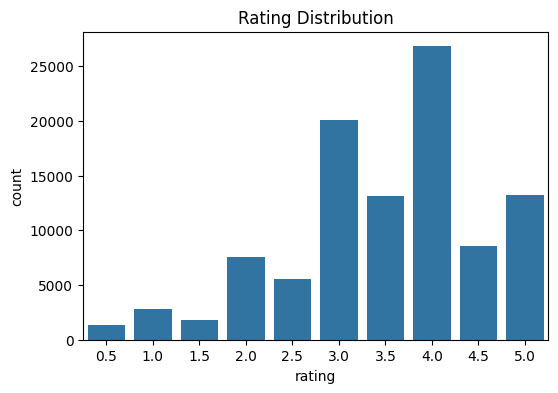

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=ratings)
plt.title("Rating Distribution")
plt.show()

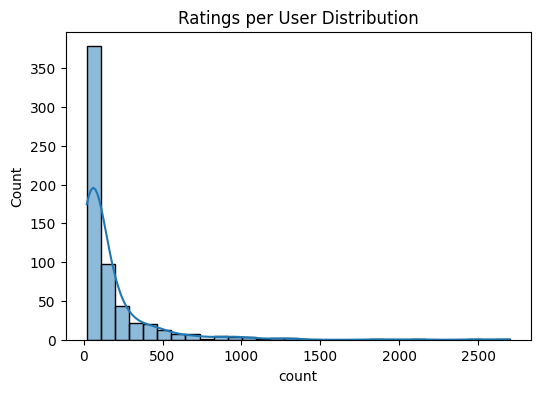

In [11]:
user_counts = ratings['userId'].value_counts()

plt.figure(figsize=(6,4))
sns.histplot(user_counts, bins=30, kde=True)
plt.title("Ratings per User Distribution")
plt.show()

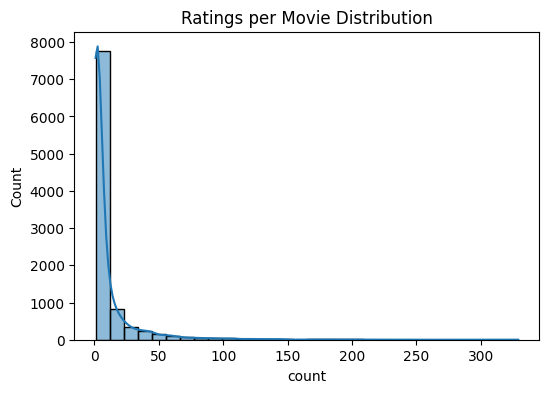

In [12]:
movie_counts = ratings['movieId'].value_counts()

plt.figure(figsize=(6,4))
sns.histplot(movie_counts, bins=30, kde=True)
plt.title("Ratings per Movie Distribution")
plt.show()

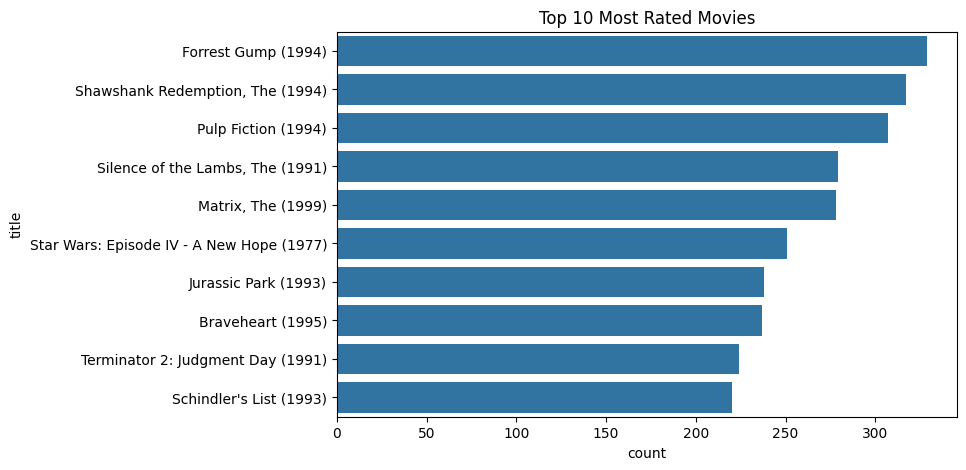

In [13]:
top_movies = ratings['movieId'].value_counts().head(10)
top_movies_df = pd.DataFrame({
    'movieId': top_movies.index,
    'count': top_movies.values
}).merge(movies, on='movieId')

plt.figure(figsize=(8,5))
sns.barplot(x='count', y='title', data=top_movies_df)
plt.title("Top 10 Most Rated Movies")
plt.show()

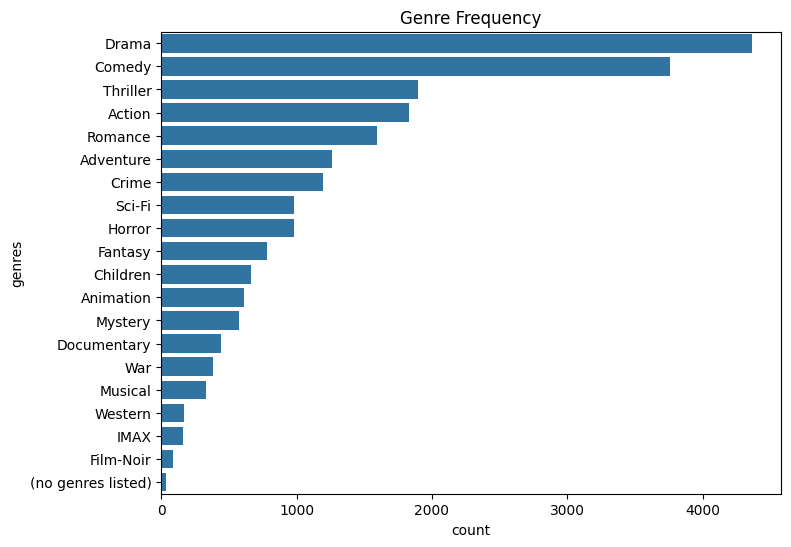

In [14]:
genres = movies['genres'].str.split('|').explode()

plt.figure(figsize=(8,6))
sns.countplot(y=genres, order=genres.value_counts().index)
plt.title("Genre Frequency")
plt.show()

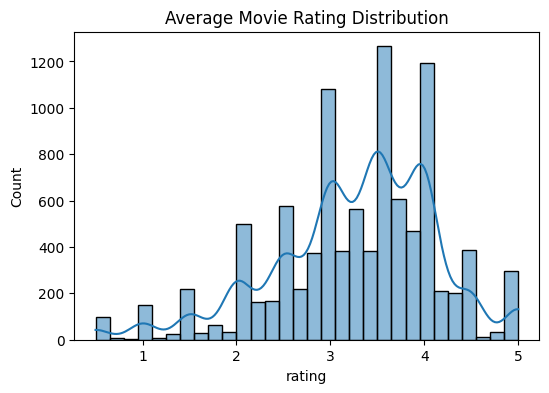

In [15]:
avg_movie = ratings.groupby('movieId')['rating'].mean()

plt.figure(figsize=(6,4))
sns.histplot(avg_movie, bins=30, kde=True)
plt.title("Average Movie Rating Distribution")
plt.show()

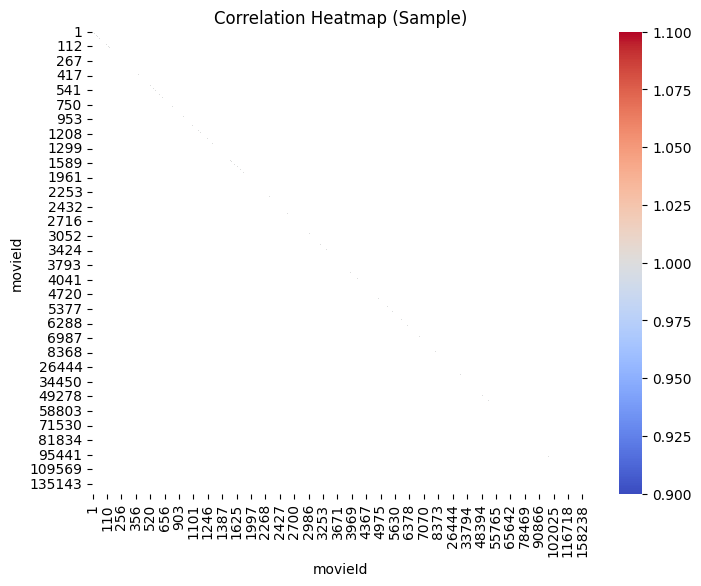

In [16]:
sample = ratings.sample(1000)
pivot = sample.pivot_table(index='userId', columns='movieId', values='rating')

plt.figure(figsize=(8,6))
sns.heatmap(pivot.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap (Sample)")
plt.show()

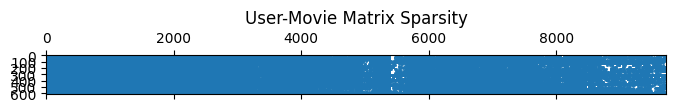

In [17]:
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

plt.figure(figsize=(8,6))
plt.spy(user_movie_matrix.fillna(0), markersize=1)
plt.title("User-Movie Matrix Sparsity")
plt.show()

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

movies['genres'] = movies['genres'].replace("(no genres listed)", "")
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

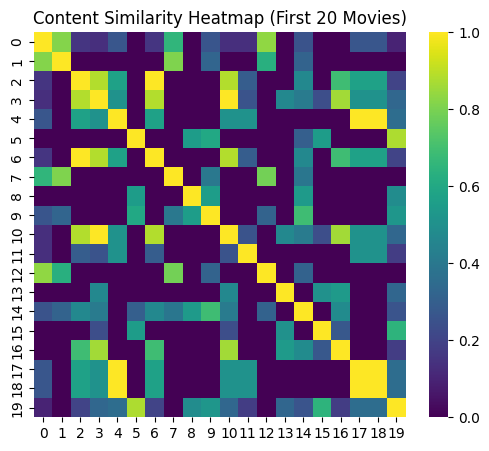

In [20]:
plt.figure(figsize=(6,5))
sns.heatmap(cosine_sim[:20,:20], cmap="viridis")
plt.title("Content Similarity Heatmap (First 20 Movies)")
plt.show()

In [23]:
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split as surprise_split

reader = Reader(rating_scale=(0.5,5))
data_surprise = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)
trainset, testset = surprise_split(data_surprise, test_size=0.2)

In [24]:
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split as surprise_split

reader = Reader(rating_scale=(0.5,5))
data_surprise = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)
trainset, testset = surprise_split(data_surprise, test_size=0.2)

In [26]:
from surprise import KNNBasic, accuracy

sim_user = {"name":"cosine","user_based":True}
knn_model = KNNBasic(sim_options=sim_user)
knn_model.fit(trainset)
predictions_knn = knn_model.test(testset)

rmse_knn = accuracy.rmse(predictions_knn)
mae_knn = accuracy.mae(predictions_knn)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9645
MAE:  0.7447


In [27]:
sim_item = {"name":"cosine","user_based":False}
item_model = KNNBasic(sim_options=sim_item)
item_model.fit(trainset)
predictions_item = item_model.test(testset)

rmse_item = accuracy.rmse(predictions_item)
mae_item = accuracy.mae(predictions_item)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9682
MAE:  0.7535


In [29]:
from surprise import SVD, accuracy

svd_model = SVD()
svd_model.fit(trainset)
predictions_svd = svd_model.test(testset)

rmse_svd = accuracy.rmse(predictions_svd)
mae_svd = accuracy.mae(predictions_svd)

RMSE: 0.8678
MAE:  0.6669


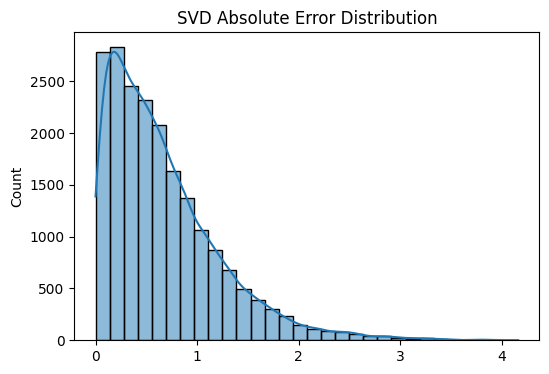

In [30]:
errors_svd = [abs(pred.est - pred.r_ui) for pred in predictions_svd]

plt.figure(figsize=(6,4))
sns.histplot(errors_svd, bins=30, kde=True)
plt.title("SVD Absolute Error Distribution")
plt.show()

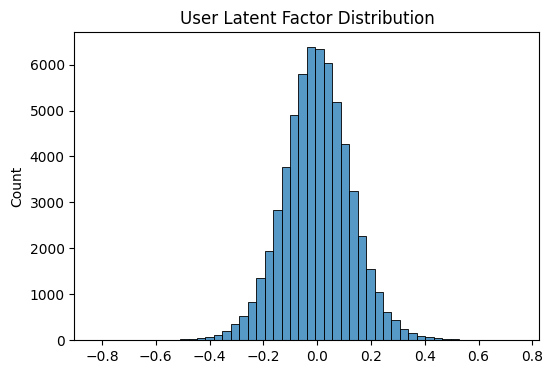

In [31]:
plt.figure(figsize=(6,4))
sns.histplot(svd_model.pu.flatten(), bins=50)
plt.title("User Latent Factor Distribution")
plt.show()

In [32]:
results = pd.DataFrame({
    "Model":["User-Based CF","Item-Based CF","SVD"],
    "RMSE":[rmse_knn, rmse_item, rmse_svd],
    "MAE":[mae_knn, mae_item, mae_svd]
})

results

,Model,RMSE,MAE
0,User-Based CF,0.964450,0.744723
1,Item-Based CF,0.968172,0.753470
2,SVD,0.867760,0.666882


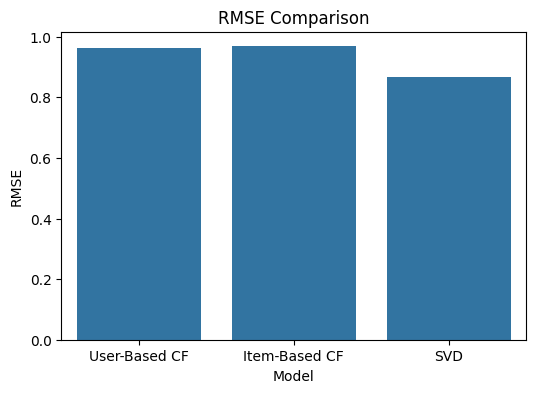

In [33]:
plt.figure(figsize=(6,4))
sns.barplot(x="Model", y="RMSE", data=results)
plt.title("RMSE Comparison")
plt.show()

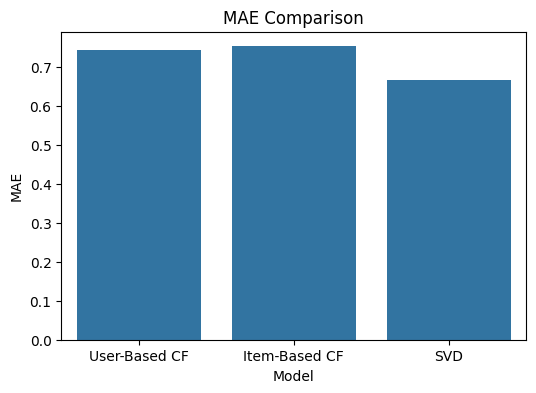

In [34]:
plt.figure(figsize=(6,4))
sns.barplot(x="Model", y="MAE", data=results)
plt.title("MAE Comparison")
plt.show()

In [35]:
# ==============================
# INTERACTIVE RECOMMENDATION CELL
# ==============================

def recommend_svd(user_id, n=5):
    movie_ids = movies['movieId'].unique()
    predictions = []

    for movie_id in movie_ids:
        pred = svd_model.predict(user_id, movie_id)
        predictions.append((movie_id, pred.est))

    predictions.sort(key=lambda x: x[1], reverse=True)
    top_movies = predictions[:n]

    recommended_titles = []
    for movie_id, rating in top_movies:
        title = movies[movies['movieId'] == movie_id]['title'].values[0]
        recommended_titles.append((title, round(rating,2)))

    return recommended_titles


def recommend_knn(user_id, n=5):
    movie_ids = movies['movieId'].unique()
    predictions = []

    for movie_id in movie_ids:
        pred = knn_model.predict(user_id, movie_id)
        predictions.append((movie_id, pred.est))

    predictions.sort(key=lambda x: x[1], reverse=True)
    top_movies = predictions[:n]

    recommended_titles = []
    for movie_id, rating in top_movies:
        title = movies[movies['movieId'] == movie_id]['title'].values[0]
        recommended_titles.append((title, round(rating,2)))

    return recommended_titles


# ===== USER INPUT =====

user_id = int(input("Enter User ID: "))
model_choice = input("Choose Model (svd / knn): ").lower()
top_n = int(input("How many recommendations?: "))


if model_choice == "svd":
    recs = recommend_svd(user_id, top_n)
elif model_choice == "knn":
    recs = recommend_knn(user_id, top_n)
else:
    print("Invalid model choice")
    recs = []

print("\nRecommended Movies:\n")
for title, rating in recs:
    print(f"{title}  |  Predicted Rating: {rating}")

Enter User ID: 1
Choose Model (svd / knn): svd
How many recommendations?: 1

Recommended Movies:

Taxi Driver (1976)  |  Predicted Rating: 5
